Install Torchvision and Pillow.

In [1]:
!pip install torch torchvision
!pip install Pillow==7.0.0

     |████████████████████████████████| 2.1 MB 7.7 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 7.0.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Import torch, matplotlib, numpy and torchvision.

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
import os
import requests
import shutil
from torchvision import datasets, transforms, models
from pathlib import Path
import tarfile

Set the device type variable to cuda or cpu.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device = {device}')

device = cuda:0


Get the Training, Validation & Testing dataset.

http://ai.stanford.edu/~jkrause/cars/car_dataset.html

The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

In [4]:
def download_tar_gz_files(url, destination_path, destination_tar_file_name='downloaded_file.tgz'):
  # Delete the destination path if it already exist in the current environment.
  if os.path.exists(destination_path):
    shutil.rmtree(destination_path)
  
  # Create a new destination directory path.
  os.mkdir(destination_path)
  
  # Download the url to the destination - downloaded_file.tgz.
  response = requests.get(url, stream=True)
  if response.status_code == 200:
    with open(os.path.join(destination_path, destination_tar_file_name), 'wb') as f:
      f.write(response.raw.read())

  # Untar the downloaded file to the destination path.
  tar_file = tarfile.open(os.path.join(destination_path, destination_tar_file_name))
  tar_file.extractall(destination_path) # specify which folder to extract to
  tar_file.close()

  # Print the total number of files in the tar file.
  print(destination_path)
  pathlist = destination_path.glob('**/*.jpg')
  image_path_list = []
  for path in pathlist:
    image_path_list.append(str(path))
  print(f"There are {len(image_path_list)} images in this path.")  

Download training data - http://imagenet.stanford.edu/internal/car196/cars_train.tgz

In [5]:
training_url = 'http://ai.stanford.edu/~jkrause/car196/cars_train.tgz'
cars_training_path = Path('./cars_training') # Create a path object and pass in the name of the directory ("cars_training") where you will be downloading the dataset.
download_tar_gz_files(training_url, cars_training_path)

cars_training
There are 8144 images in this path.


Download testing data - http://imagenet.stanford.edu/internal/car196/cars_test.tgz

In [6]:
testing_url = 'http://ai.stanford.edu/~jkrause/car196/cars_test.tgz'
cars_testing_path = Path('./cars_testing')
download_tar_gz_files(testing_url, cars_testing_path)

cars_testing
There are 8041 images in this path.


A devkit, including class labels for training images and bounding boxes for all images, can be downloaded here - http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz

In [7]:
annotations_url = 'http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz'
cars_annotations_path = Path('./cars_annotations')
download_tar_gz_files(annotations_url, cars_annotations_path)

cars_annotations
There are 0 images in this path.


Download test annotations with labels - http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat

In [8]:
annotations_test_url = 'http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat'
cars_test_annotations_path = Path('./cars_annotations/devkit/cars_test_annos_withlabels.mat')
# Download the url to the destination - downloaded_file.tgz.
response = requests.get(annotations_test_url, stream=True)
if response.status_code == 200:
  with open(cars_test_annotations_path, 'wb') as f:
    f.write(response.raw.read())

Save the annotations to variables.

In [9]:
cars_test_annos = 'cars_annotations/devkit/cars_test_annos_withlabels.mat'
car_train_annos = 'cars_annotations/devkit/cars_train_annos.mat'
car_meta_annos = 'cars_annotations/devkit/cars_meta.mat'

Install console progress bar to observe the progression of preparing training and testing data based upon the annotations.

In [10]:
!pip install console_progressbar

  Created wheel for console-progressbar: filename=console_progressbar-1.1.2-py3-none-any.whl size=4156 sha256=b45a0ec83e4aab0cfb7ab5660e60d5958aaf2e738e49ccb4d96f3d6809af8ef9
  Stored in directory: /root/.cache/pip/wheels/2b/5f/7d/97976c8b046302df5781c0cbb18fd04b9d58467edae9942bfa
Successfully built console-progressbar


Import the necessary packages

In [11]:
import tarfile
import numpy as np
import scipy.io
import os
import cv2 as cv
import shutil
import random
import re
from console_progressbar import ProgressBar

Load the class name into a list. Sanitize the class names by replacing whitespaces with _ which will be used to create sub directories under test and train output. Example: "Ram C/V Cargo Van Minivan 2012" -> Ram_C_V_Cargo_Van_Minivan_2012

Use scipy.io.loadmat to load the annotations which is in .mat format. Get all the cars_name_list by replacing white spaces with '_' symbol.

In [12]:
cars_name_list = []
print(f"Processing annotations metadata {car_meta_annos}")
cars_meta = scipy.io.loadmat(car_meta_annos)
class_names = cars_meta['class_names']  # shape=(1, 196)
class_names = np.transpose(class_names)
print('class_names.shape: ' + str(class_names.shape))
print(f'type of class_names = {type(class_names)}')
print(f'size of class_names = {class_names.size}')
for index in range(class_names.size):
  # Replace white space and / with _. Example: "Ram C/V Cargo Van Minivan 2012" -> Ram_C_V_Cargo_Van_Minivan_2012
  cars_name_list.append(re.sub(r"(/|\s+)", r'_', class_names[index][0][0]))

print('length of cars_name_list = {}, Sample class_name: [{}]'.format(len(cars_name_list), cars_name_list[3]))

Processing annotations metadata cars_annotations/devkit/cars_meta.mat
class_names.shape: (196, 1)
type of class_names = <class 'numpy.ndarray'>
size of class_names = 196
length of cars_name_list = 196, Sample class_name: [Acura_TL_Type-S_2008]


For each of the class name, create a sub directory in cars_testing_output directory and cars_training_output directory.

In [13]:
cars_training_output_path = Path('./cars_training_output')
# Delete the training output dir.
if os.path.exists(cars_training_output_path):
  shutil.rmtree(cars_training_output_path)
if not cars_training_output_path.exists():
    cars_training_output_path.mkdir()

Process the train data and classify them into the cars_testing_output and cars_training_output directory with the correct class name as the sub directory name.

In [14]:
def create_destination_directory_with_names(dest, name_list):
  #Create sub directories with the name of the car names in the destination.
  print("creating sub directories in {} with names found in {}.".format(
      dest, name_list))
  for o in name_list:
    final_dest = (dest/o)
    final_dest.mkdir(exist_ok=True)


create_destination_directory_with_names(cars_training_output_path, cars_name_list)

creating sub directories in cars_training_output with names found in ['AM_General_Hummer_SUV_2000', 'Acura_RL_Sedan_2012', 'Acura_TL_Sedan_2012', 'Acura_TL_Type-S_2008', 'Acura_TSX_Sedan_2012', 'Acura_Integra_Type_R_2001', 'Acura_ZDX_Hatchback_2012', 'Aston_Martin_V8_Vantage_Convertible_2012', 'Aston_Martin_V8_Vantage_Coupe_2012', 'Aston_Martin_Virage_Convertible_2012', 'Aston_Martin_Virage_Coupe_2012', 'Audi_RS_4_Convertible_2008', 'Audi_A5_Coupe_2012', 'Audi_TTS_Coupe_2012', 'Audi_R8_Coupe_2012', 'Audi_V8_Sedan_1994', 'Audi_100_Sedan_1994', 'Audi_100_Wagon_1994', 'Audi_TT_Hatchback_2011', 'Audi_S6_Sedan_2011', 'Audi_S5_Convertible_2012', 'Audi_S5_Coupe_2012', 'Audi_S4_Sedan_2012', 'Audi_S4_Sedan_2007', 'Audi_TT_RS_Coupe_2012', 'BMW_ActiveHybrid_5_Sedan_2012', 'BMW_1_Series_Convertible_2012', 'BMW_1_Series_Coupe_2012', 'BMW_3_Series_Sedan_2012', 'BMW_3_Series_Wagon_2012', 'BMW_6_Series_Convertible_2007', 'BMW_X5_SUV_2007', 'BMW_X6_SUV_2012', 'BMW_M3_Coupe_2012', 'BMW_M5_Sedan_2010', '

Organize training data into sub-folders containing the class name as the sub-folder name.

In [15]:
img_width, img_height = 224, 224
cars_training_path = Path('./cars_training/cars_train') 

def save_train_data(fnames, labels, bboxes):
    src_folder = (cars_training_path)
    dst_folder = cars_training_output_path
    num_samples = len(fnames)
    pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')
    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))
        pb.print_progress_bar((i + 1) * 100 / num_samples)
        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)
        

training_fnames = []
training_class_ids = []
training_bboxes = []
training_labels = []
training_labels_count=0

def process_train_data():
    print(f"Processing train data {car_train_annos}.")
    cars_annos = scipy.io.loadmat(car_train_annos)
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        #labels.append('%04d' % (class_id,))
        #print(f'class_id = {class_id}')
        training_labels.append(cars_name_list[class_id-1])
        fname = annotation[0][5][0]
        training_bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        training_class_ids.append(class_id)
        training_fnames.append(fname)

    save_train_data(training_fnames, training_labels, training_bboxes)

if not len(training_labels):
  process_train_data()
training_labels_count=len(np.unique(training_labels))

Processing train data cars_annotations/devkit/cars_train_annos.mat.
Save train data |==================================================| 100.000% 


Print the total number of downloaded cars training files.

In [16]:
pathlist = cars_training_path.glob('**/*.jpg')
image_path_list = []
for path in pathlist:
  image_path_list.append(str(path))
print(f"There are {len(image_path_list)} images in this path.")  

There are 8144 images in this path.


Print the training class ids, training labels, training_fnames and the total number of unique cars used for training.

In [17]:
print("training_class_ids = {}.".format(np.unique(training_class_ids)))
print("training_labels = {}.".format(np.unique(training_labels)))
print("training_fnames = {}.".format(training_fnames))
print('The number of different cars = {}'.format(training_labels_count))

training_class_ids = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196].
training_labels = ['AM_General_Hummer_SUV_2000' 'Acura_Integra_Type_R_2001'
 'Acura_RL_Sedan_2012' 'Acura_TL_Sedan_2012' 'Acura_TL_Type-S_2008'
 'Acura_TSX_Sedan_2012' 'Acura_ZDX_Hat

Prepare test data by creating sub-folders with the name of the car (class) as the sub-folder name.

Predicting on the test set.training_data.csv contains a test file_named in the cars_training_output directory mapped to a class label.

Example: training_data.csv file_name = cars_testing_output/00001.jpg
label = Suzuki_Aerio_Sedan_2007

Load the cars test annotations

In [18]:
cars_testing_output_path = Path('./cars_testing_output')
if os.path.exists(cars_testing_output_path):
  shutil.rmtree(cars_testing_output_path)

if not os.path.exists(cars_testing_output_path):
    cars_testing_output_path.mkdir()

Create a .csv file for test data.

In [19]:
import csv

img_width, img_height = 224, 224

cars_testing_path = Path('./cars_testing/cars_test')

def save_test_data(fnames, labels, bboxes):
  src_folder = (cars_testing_path)
  dst_folder = cars_testing_output_path
  num_samples = len(fnames)
  pb = ProgressBar(total=100, prefix='Save test data', suffix='', decimals=3, length=50, fill='=')
  
  with open('testing_data.csv', 'a', newline='') as file:
    fieldnames = ['file_name', 'label']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(num_samples):
      fname = fnames[i]
      label = labels[i]
      (x1, y1, x2, y2) = bboxes[i]
      src_path = os.path.join(src_folder.as_posix(), fname)
      src_image = cv.imread(src_path)
      height, width = src_image.shape[:2]
      # margins of 16 pixels
      margin = 16
      x1 = max(0, x1 - margin)
      y1 = max(0, y1 - margin)
      x2 = min(x2 + margin, width)
      y2 = min(y2 + margin, height)
      # print("{} -> {}".format(fname, label))
      pb.print_progress_bar((i + 1) * 100 / num_samples)
      dst_path = os.path.join(dst_folder, fname)

      crop_image = src_image[y1:y2, x1:x2]
      dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
      cv.imwrite(dst_path, dst_img)
      #writer.writerow({'file_name': dst_path, 'label': label})
      writer.writerow({'file_name': fname, 'label': label})
    
    #write the training data label.
    with open('testing_data_label.csv', 'a', newline='') as training_label:
      for i in range(num_samples):
        training_label.write(labels[i] + '\n')

def process_test_data():
    print(f"Processing test data {cars_test_annos}.")
    cars_annos = scipy.io.loadmat(cars_test_annos)
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        #labels.append('%04d' % (class_id,))
        #print(f'class_id = {class_id}')
        labels.append(cars_name_list[int(class_id)-1])
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print(np.unique(labels))
    print('The number of different cars is %d' % labels_count)

    save_test_data(fnames, labels, bboxes)

process_test_data()

Processing test data cars_annotations/devkit/cars_test_annos_withlabels.mat.
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
['AM_General_Hummer_SUV_2000' 'Acura_Integra_Type_R_2001'
 'Acura_RL_Sedan_2012' 'Acura_TL_Sedan_2012' 'Acura_TL_Type-S_2008'
 

Print the total number of formatted training and testing files.

In [20]:
print("Total number of training files = {}.".format(len([iq for iq in os.scandir('cars_training/cars_train')])))
print("Total number of testing files = {}.".format(len([iq for iq in os.scandir('cars_testing/cars_test')])))

Total number of training files = 8144.
Total number of testing files = 8041.


Split training set into 80% training set and 20% validation set.

In [21]:
!pip install split-folders tqdm

In [22]:
import splitfolders  # or import split_folders
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("./cars_training_output", output="./cars_training_validation_output", seed=1337, ratio=(.8, .2), group_prefix=None) # default values


Copying files: 8144 files [00:01, 6113.76 files/s]


Create the data transforms object for training set.

In [23]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


Create the validation data transform object for augmenting the image and resizing the image to fit into an existing pre-trained model.

In [24]:
transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

Point to the training and testing data set directories containing the images with the name of the classification image as the name of the directory. Use the data transformation objects to perform data augmentation.

In [25]:
training_dataset = datasets.ImageFolder('cars_training_validation_output/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('cars_training_validation_output/val', transform=transform)

print(f'training_dataset length = {len(training_dataset)}')
print(f'validation_dataset length = {len(validation_dataset)}')

training_dataset length = 6442
validation_dataset length = 1702


Create training and validation dataloader objects with a reasonable batch size.

In [26]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Define a function to transpose the image.

In [27]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

Define the classes used in feature classification.

In [28]:
classes = [x for x in np.unique(training_labels)]
print(classes)

['AM_General_Hummer_SUV_2000', 'Acura_Integra_Type_R_2001', 'Acura_RL_Sedan_2012', 'Acura_TL_Sedan_2012', 'Acura_TL_Type-S_2008', 'Acura_TSX_Sedan_2012', 'Acura_ZDX_Hatchback_2012', 'Aston_Martin_V8_Vantage_Convertible_2012', 'Aston_Martin_V8_Vantage_Coupe_2012', 'Aston_Martin_Virage_Convertible_2012', 'Aston_Martin_Virage_Coupe_2012', 'Audi_100_Sedan_1994', 'Audi_100_Wagon_1994', 'Audi_A5_Coupe_2012', 'Audi_R8_Coupe_2012', 'Audi_RS_4_Convertible_2008', 'Audi_S4_Sedan_2007', 'Audi_S4_Sedan_2012', 'Audi_S5_Convertible_2012', 'Audi_S5_Coupe_2012', 'Audi_S6_Sedan_2011', 'Audi_TTS_Coupe_2012', 'Audi_TT_Hatchback_2011', 'Audi_TT_RS_Coupe_2012', 'Audi_V8_Sedan_1994', 'BMW_1_Series_Convertible_2012', 'BMW_1_Series_Coupe_2012', 'BMW_3_Series_Sedan_2012', 'BMW_3_Series_Wagon_2012', 'BMW_6_Series_Convertible_2007', 'BMW_ActiveHybrid_5_Sedan_2012', 'BMW_M3_Coupe_2012', 'BMW_M5_Sedan_2010', 'BMW_M6_Convertible_2010', 'BMW_X3_SUV_2012', 'BMW_X5_SUV_2007', 'BMW_X6_SUV_2012', 'BMW_Z4_Convertible_2012

Define a data iterator class pointing to the training dataloader object.

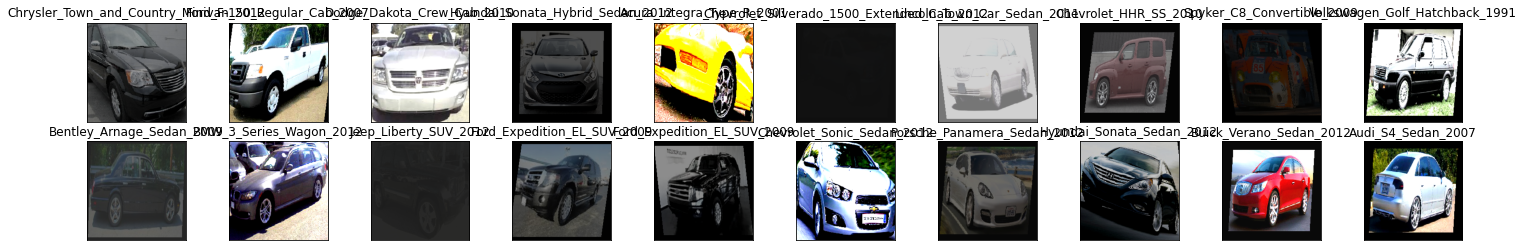

In [29]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

Pick AlexNet or VGG16 as the pre-trained model.

In [30]:
model = models.vgg16(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

For each param in model features, set the requires_grad = False

In [31]:
for param in model.features.parameters():
  param.requires_grad = False

Import torch basic building blocks for graphs (visions, loss,...)

In [32]:
import torch.nn as nn

Note that the last layer (layer 6) in the pre-trained classifer has 1000 features, we just want to set the feature set to the total number of classes that we want. Therefore, we try to edit layer 6 in the classifier and set the total number of classes that we are interested in.

In [33]:
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)

196


Print the model with the newly set features for the layer 6 in the classifier.

In [34]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Start the model training process. Pick the correct loss function and the correct optimizer function with a reasonable learning rate (much slower as there are a few number of classification class types).

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
epochs = 20
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

At the end of each epoch, print the training loss and validation loss.

In [36]:
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
 
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.0524, acc 0.0185 
validation loss: 0.0511, validation acc 0.0394 
epoch : 2
training loss: 0.0467, acc 0.0571 
validation loss: 0.0440, validation acc 0.0993 
epoch : 3
training loss: 0.0409, acc 0.1156 
validation loss: 0.0380, validation acc 0.1463 
epoch : 4
training loss: 0.0365, acc 0.1768 
validation loss: 0.0345, validation acc 0.1933 
epoch : 5
training loss: 0.0330, acc 0.2353 
validation loss: 0.0315, validation acc 0.2233 
epoch : 6
training loss: 0.0299, acc 0.2802 
validation loss: 0.0297, validation acc 0.2726 
epoch : 7
training loss: 0.0276, acc 0.3261 
validation loss: 0.0280, validation acc 0.3190 
epoch : 8
training loss: 0.0255, acc 0.3814 
validation loss: 0.0271, validation acc 0.3184 
epoch : 9
training loss: 0.0243, acc 0.4041 
validation loss: 0.0253, validation acc 0.3619 
epoch : 10
training loss: 0.0227, acc 0.4402 
validation loss: 0.0247, validation acc 0.3872 
epoch : 11
training loss: 0.0209, acc 0.4728 
validation loss: 0.0242

Print the plot of training loss, validation loss

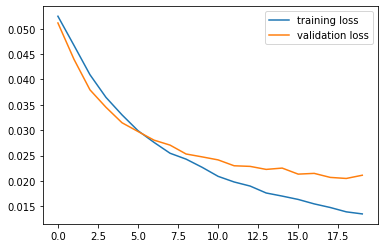

In [37]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

Print training accuracy and validation accuracy.

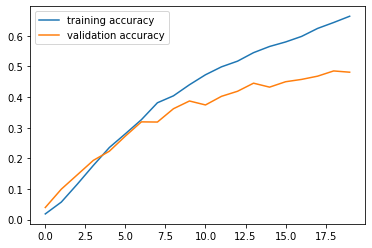

In [38]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

This is an example of how to use cv2 video writer to write a video frame.

In [39]:
# import cv2 
 
# frame_height, frame_width, _ = im_convert(target).shape
# vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))
 
# for i in range(0, 300):
#   img = image_array[i]
#   img = img*255
#   img = np.array(img, dtype = np.uint8)
#   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   vid.write(img)
 
# vid.release()

Copy/Paste a test data from the internet and check how well the model hypothesis output matches with the groundtruth data.



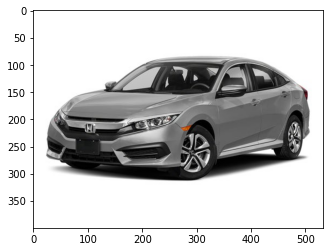

In [51]:
import PIL.ImageOps
import requests
from PIL import Image
 
url = 'https://www.hondamarysville.com/assets/stock/colormatched_01/white/640/cc_2018hoc020013_01_640/cc_2018hoc020013_01_640_si.jpg?height=400'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

Try transforming the image.

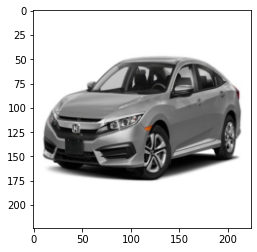

In [52]:
img = transform(img) 
plt.imshow(im_convert(img))

Print the class name for the specified input test data image.

In [126]:
image = img.to(device).unsqueeze(0)
output = model(image)
#print(f'output={output}')
#print(f'torch.topk = {torch.topk(output, 20)}')
topk_values, topk_indices = torch.topk(output, 20)
#print(f'topk_values={topk_values}, topk_indices={topk_indices}')
for index2 in topk_indices:
  print(f'index2={index}')
  for index in index2:
    print(classes[index])
#x, pred = torch.max(output, 1)
#print(classes[pred.item()])
#print(f'pred={pred}')
#print(f'x={x}')

index2=2
Hyundai_Sonata_Sedan_2012
Hyundai_Accent_Sedan_2012
Hyundai_Sonata_Hybrid_Sedan_2012
BMW_3_Series_Wagon_2012
Buick_Regal_GS_2012
Volvo_C30_Hatchback_2012
Tesla_Model_S_Sedan_2012
Audi_TT_RS_Coupe_2012
Acura_TL_Sedan_2012
Hyundai_Genesis_Sedan_2012
Audi_S5_Coupe_2012
BMW_1_Series_Coupe_2012
Mercedes-Benz_C-Class_Sedan_2012
BMW_M3_Coupe_2012
Chevrolet_Malibu_Hybrid_Sedan_2010
Mercedes-Benz_SL-Class_Coupe_2009
Hyundai_Veloster_Hatchback_2012
Audi_S6_Sedan_2011
BMW_X6_SUV_2012
Cadillac_CTS-V_Sedan_2012


Use the validation set to validate how well the model performs on it.

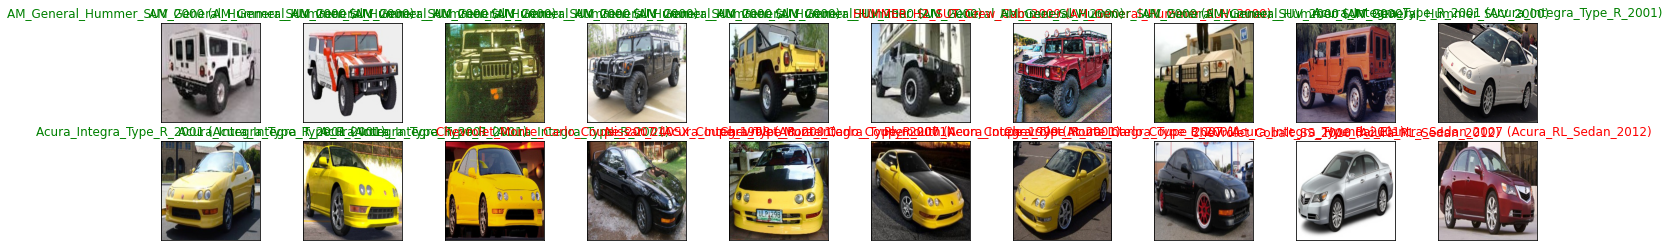

In [129]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
 
output = model(images)
 
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
   ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
   plt.imshow(im_convert(images[idx]))
   ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))


Validate the testing accuracy.

caught an exception [Errno 2] No such file or directory: './cars_testing_output/file_name'
------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-160-f5a6ecfd0616>", line 25, in <module>
    with Image.open(img_path) as img:
  File "/usr/local/lib/python3.7/dist-packages/PIL/Image.py", line 2843, in open
    fp.close()
FileNotFoundError: [Errno 2] No such file or directory: './cars_testing_output/file_name'
------------------------------------------------------------


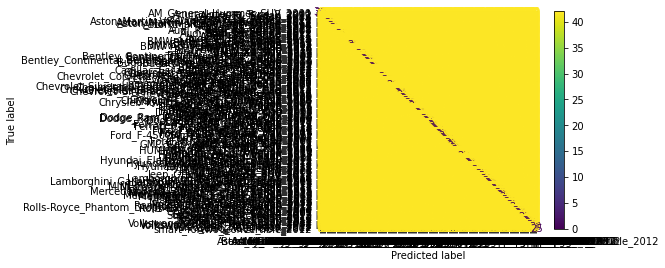

<Figure size 86400x86400 with 0 Axes>

                                                        precision    recall  f1-score   support

                            AM_General_Hummer_SUV_2000       0.85      0.77      0.81        44
                             Acura_Integra_Type_R_2001       0.48      0.73      0.58        44
                                   Acura_RL_Sedan_2012       0.33      0.19      0.24        32
                                   Acura_TL_Sedan_2012       0.38      0.26      0.31        43
                                  Acura_TL_Type-S_2008       1.00      0.07      0.13        42
                                  Acura_TSX_Sedan_2012       0.45      0.12      0.20        40
                              Acura_ZDX_Hatchback_2012       0.85      0.28      0.42        39
              Aston_Martin_V8_Vantage_Convertible_2012       0.24      0.33      0.28        45
                    Aston_Martin_V8_Vantage_Coupe_2012       0.37      0.32      0.34        41
                  Aston_Martin_Virage_C

In [160]:
from collections import defaultdict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import sys, traceback
#from fastai.vision.data import ImageDataLoaders

#learn = load_learner('cars_model.pkl', test= 
#                     ImageDataLoaders.from_csv('./','labels.csv',
#                                        folder=cars_testing_output_path))
#preds,y = learn.TTA(ds_type=DatasetType.Test)
fieldnames = ['file_name', 'label']
invalid_pred = defaultdict(list)
invalid_pred_count=0
y_true = []
y_pred = []
cars_testing_output_path = './cars_testing_output/{}'

with open('./testing_data.csv') as test:
    reader = csv.DictReader(test, fieldnames=fieldnames)
    for index, row in enumerate(reader):
      try:
        # pred = learn.predict((cars_testing_output_path/row['file_name']))
        img_path = cars_testing_output_path.format(row['file_name'])
        with Image.open(img_path) as img:
          img = transform(img)
          image = img.to(device).unsqueeze(0)
          pred = model(image)
          x, pred = torch.max(pred, 1)
          # print(f'pred={pred}')
          y_true.append(row['label'])
          y_pred.append(classes[pred.item()])
          if pred[0] != row['label']:
            invalid_pred[row['label']].append("File: {}, \
            actual_pred={}".format(row['file_name'], pred[0]))
            invalid_pred_count+=1
          index +=1
      except Exception as e:
        print(f'caught an exception {e}')
        print("-"*60)
        traceback.print_exc(file=sys.stdout)
        print("-"*60)
        continue

display = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.figure(figsize=(1200,1200))
plt.show(display.plot)
print(classification_report(y_true, y_pred))
print("invalid_pred_count= {}".format(invalid_pred_count))
# print(json.dumps(invalid_pred, indent=4, sort_keys=True))